## Free Response Answers
1. The Enron case was at the time America's largest corporate fraud - such a scheme could not have resuted without a group of people deliberately misleading people. The goal of the project was to train a machine learning algorithm over the data available to identify Persons of Interest (POIs) from a dataset that included financial data and email data from the investigation. Here we had many different fields and so the advatage of a machine learnign algortihm is its ability to find patterns in the data in many dimensions - we then are able to leverage those patterns and apply them to new datasets.

 On an initial explatory data analysis (EDA) sweep of the data, we see the data scraping process has picked up the "TOTAL" row in the data - this is an outlier that we remove. After removing this we see that we are left with 149 people. However we have no data for "Eugene E Lockhart" - he is not a POI however. We could delete him from the dataset as well, however since he has no values - he will be removed by the featureFormat function. This leaves us with 148 persons, with 18 POIs.
  
2. The feature that was added to the data set was to express emails to and from POIs as a ratio of total emails to and from the person. This was becasue our inital EDA showed that absolute values of emails were not very helpful - but when scaled to be expressed as a proportion of that persons's total email count, the ratio was more useful.

 While some initial EDA was done, this would not be very efficient as we would be limited to looking at 2 features compared against each other at a time. Therefore we used a SelectKBest in conjunction with GridSearchCV to select the best features. SelectKBest returned:
 >('bonus', 30.652282305660439)  
 >('salary', 15.806090087437418)  
 >('from_this_person_to_poi_ratio', 13.791413236761116)  
 >('total_stock_value', 10.814634863040405)  
 >('exercised_stock_options', 9.9561675820785211)  
 >('deferred_income', 8.4934970305461821)  
 >('restricted_stock', 8.0511018969982544)  
 >('long_term_incentive', 7.5345222400328424)  
 >('loan_advances', 7.0379327981934612)  
 >('expenses', 4.3143955730810664)  
 >('other', 3.1966845043285219)  
 >('director_fees', 1.6410979261701475)  
 >('restricted_stock_deferred', 0.67928033895169282)  
 >('from_poi_to_this_person_ratio', 0.49060990360486301)  
 >('deferral_payments', 0.0098194464190455126)
 
 Feature scaling was used in the pipeline as we were testing algorithms that were variance dependent (e.g. SVC). However, in my final submission this was not used as algorithm settled on (decision tree) does not require scaling of features.
 
3. The algorithm settled on was using a decision tree as a classifier. Other algorithms tried include: naive Bayes, support vector classifiers and k-nearest neighbours. While all algortihms delivered a similar amount of accuracy, I found that the decision tree classifier performed best at recognising POIs in the data - this was an important consideration as the number of POIs in the dataset was low.

4. Tuning the parameters of an algorithm refers to determining how the algorithm makes decisions on how to classify the data points. When it comes to the decision that the algorithm makes around how to classify points, we are trying to balance the trade-off between bias and variance. If the algorithm is not properly tuned it may be hgihly biased - that is it will apply rules too generally and miss intricacies in the data. On the other hand, if tuned to finely to the parameters of the training set, the algorithm may only be alble to make good decions on data it has already seen. In both cases, we will get poor performance on a new test dataset - therefore we tune the algorithm to be responsive enough to unique cases in the data, while being able to perform well on new data sets it has not yet seen.

 For the decision tree, I ended up tuning the criterion and min_sample_split parameter. The criterion parameter determines how the algorithm makes a split - here we ended up specifying "entropy" so the algorithm makes it's decision to maximise information gain. min_sample_split determines the minimum number of samples that will allow the algortihm to split a node - if this is too small we can lead the algorithm to have high variance (i.e. it will overfit the training set), however if too high the bias of the algorithm will be too high. In tuning our algorithm we first used GridSearchCV to automate the process to find the best candidate. We then manually adjusted the, min_sample_split to give better results.
 
5. Validation involves running the algorithm on a test data set that it has not seen before. Without validation we could have overfit our model to training data without the algorithm being able to make accurate predictions on new data. Here validation is achieved by splitting out data into training and testing sets, and then we measure the algorithm's performance on the testing set. 

6. In the analysis I used the following evaluation metrics:
   * Accuracy (0.8409): this simply the proportion of the sample set that our algorithm correctly identifies. I think that this is the most important metric - if our algorithm consistently consistently 100% of points correctly that would be ideal - and also extremely suspicious. Therefore we also consider the following metrics.
   * Recall (0.4000): this is the ratio of true positives over the sum true positives and false negatives. Here this is a measure of how many POIs our algorithm correctly recognised.
   * Precision (0.3333): this ithe ration of true positives over the sum of true positives and false positves. Here we can best describe this as the probability that the a predicted POI is actually a POI (or how precise the algorithm is).

 Here, given that 100% accuracy is unlikely we have to make a decision about whether to favour **recall** or **precision**. This will vary from case to case and will require some judgement. So in this case, we note here that the number of POIs is emtremely low. Also being labelled by the algorithm as a POIs would not automatically give rise to legal consequences, rather it would probably signal that person should be investigated more thoroughly. Therefore, I feel it would generally be appropriate to aim for a higher **recall** at the expense of **precision**. However, precision is still important - we could simply maximise **recall** at the expense of **precision** by labelling everyone a POI - however this would mean that everyone would be investigated more thoroughly - which defeats the point of the algorithm - hence **precision** is still important.

## Example Code

In [1]:
# Some examples of the exploratory analysis done
#!/usr/bin/python

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Some helpful functions

# Function to quick plot
def poi_scatter(labels, data, x=0, y=1, x_label=None, y_label=None, size=150):
    """
    Function to quickly plot a scatter with poi marked out
    Defaults to plotting the second column vs. first column
    """
    n_data = len(labels)
    x_poi = [data[ii][x] for ii in range(n_data) if labels[ii] == 1]
    y_poi = [data[ii][y] for ii in range(n_data) if labels[ii] == 1]
    x_npoi = [data[ii][x] for ii in range(n_data) if labels[ii] == 0]
    y_npoi = [data[ii][y] for ii in range(n_data) if labels[ii] == 0]
    plt.scatter(x_poi, y_poi, color="r", label="poi", s=size)
    plt.scatter(x_npoi, y_npoi, color="b", label="non_poi", s=size)
    plt.legend(scatterpoints=1)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
    plt.show()

# Create a function to test our classifier
# More detailed stats
def clf_test(labels, pred):
    if len(labels) != len(pred):
        print "Lists not of same length"
        return
    tp = 0 # True positives
    tn = 0 # True negatives
    fp = 0 # False positives
    fn = 0 # False negatives
    for i in range(len(labels)):
        if labels[i] == pred[i]:
            if labels[i] == 1:
                tp += 1
            else:
                tn += 1
        else:
            if labels[i] == 0:
                fp += 1
            else:
                fn += 1
    print "Accuracy: ", ((tp+tn) / float(len(labels)))
    print "Recall: ", float(tp) / (tp + fn)
    print "Precision: ", float(tp) / (tp + fp)

In [3]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ["poi",
                 "salary",
                 "deferral_payments",
                 "loan_advances",
                 "bonus",
                 "restricted_stock_deferred",
                 "deferred_income",
                 "total_stock_value",
                 "expenses",
                 "exercised_stock_options",
                 "other",
                 "long_term_incentive",
                 "restricted_stock",
                 "director_fees",
                 "from_poi_to_this_person_ratio",
                 "from_this_person_to_poi_ratio"]

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

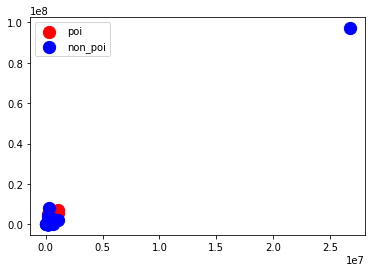

In [4]:
### Task 2: Remove outliers
# Salary and bonus plot
plot_data = featureFormat(data_dict, ["poi", "salary", "bonus"], sort_keys = True)
plot_labels, plot_features = targetFeatureSplit(plot_data)
poi_scatter(plot_labels, plot_features)

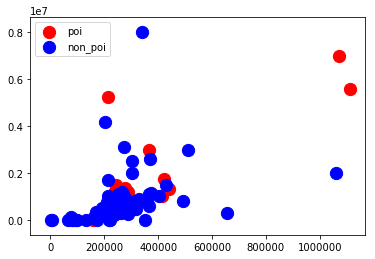

In [5]:
# From above we realise that the "TOTAL" column had been included
del data_dict["TOTAL"]

# Replot to be sure
plot_data = featureFormat(data_dict, ["poi", "salary", "bonus"], sort_keys = True)
plot_labels, plot_features = targetFeatureSplit(plot_data)
poi_scatter(plot_labels, plot_features)

In [6]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

# Feature that expresses emails to/from poi as a ratio of total emails
# Where there is no feature we save "NaN" as per featureFormat
for person in my_dataset.keys():
    person_data = my_dataset[person]
    # Create ratio for received messages
    if person_data["to_messages"] != 0 and person_data["to_messages"] != "NaN":
        if person_data["from_poi_to_this_person"] != "NaN":
            person_data["from_poi_to_this_person_ratio"] = (
                person_data["from_poi_to_this_person"] / float(person_data["to_messages"]))
        else:
            person_data["from_poi_to_this_person_ratio"] = "NaN"
    else:
        person_data["from_poi_to_this_person_ratio"] = "NaN"
    # Create ratio for from messages
    if person_data["from_messages"] != 0 and person_data["from_messages"] != "NaN":
        if person_data["from_this_person_to_poi"] != "NaN":
            person_data["from_this_person_to_poi_ratio"] = (
                person_data["from_this_person_to_poi"] / float(person_data["from_messages"]))
        else:
            person_data["from_this_person_to_poi_ratio"] = "NaN"
    else:
        person_data["from_this_person_to_poi_ratio"] = "NaN"

In [7]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Print some stats about our data
print "Total Number of People: %d" % (len(data_dict.keys()))
print "Sample: %d" % len(labels)
print "Number of POIs: %d" % sum(labels)

# Find who is missing?
print "The following has no values"
for person in my_dataset.keys():
    has_value = False
    person_data = my_dataset[person]
    for field in person_data.keys():
        field_val = person_data[field]
        if field_val != 0 and field_val != "NaN":
            has_value = True
    if not has_value:
        print "Name: %s, POI: %r" % (person, person_data["poi"])
        #print person_data

Total Number of People: 145
Sample: 144
Number of POIs: 18
The following has no values
Name: LOCKHART EUGENE E, POI: False


In [8]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Select K Best
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif)
k_range = range(len(features_list))[1:] # Test all combinations

# MinMax Scaler - useful for variance dependent classifiers (e.g. SVMs)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [9]:
# Select classifer here - loop through classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn import neighbors

clf_list = ["gaussian",
            "decision_tree",
            "svm",
            "k_neighbours"]

def set_clf_params(clf_name):
    if clf_name == "gaussian":
        clf = GaussianNB()
        params = {
            "select__k": k_range,
        }
    elif clf_name == "decision_tree":
        clf = tree.DecisionTreeClassifier()
        params = {
            "select__k": k_range,
            "clf__criterion": ["entropy", "gini"],
            "clf__min_samples_split": [2, 10, 20, 30, 40, 50]
        }
    elif clf_name == "svm":
        clf = SVC()
        params = {
            "select__k": k_range,
            "clf__kernel": ["linear", "rbf"],
            "clf__C": [1, 3, 5, 10, 20]
        }
    elif clf_name == "k_neighbours":
        clf = neighbors.KNeighborsClassifier()
        params = {
            "select__k": k_range,
            "clf__weights": ["distance", "uniform"],
            "clf__n_neighbors": [3, 5, 7, 9] # With only 18 pois, can't be too high
        }
    else:
        print "No valid selection"
        return None
    return clf, params


In [10]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
# Loop through clf
for clf_name in clf_list:
    clf, params = set_clf_params(clf_name)

    # Pipeline estimators - each should be ("name", estimator) format
    
    estimators = [("select", selector),
                  ("scaler", scaler),
                  ("clf", clf)]
    pipe = Pipeline(estimators)
    #pipe.get_params().keys()
    
    ### Task 5: Tune your classifier to achieve better than .3 precision and recall 
    ### using our testing script. Check the tester.py script in the final project
    ### folder for details on the evaluation method, especially the test_classifier
    ### function. Because of the small size of the dataset, the script uses
    ### stratified shuffle split cross validation. For more info: 
    ### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

    # Example starting point. Try investigating other evaluation techniques!
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)

    # GridSearchCV
    gridsearch = GridSearchCV(pipe, param_grid=params)

    gridsearch.fit(features_train, labels_train)
    
    print "Best results for %s" % clf_name
    print gridsearch.best_estimator_
    print "*****"

# View results below

Best results for gaussian
Pipeline(steps=[('select', SelectKBest(k=1, score_func=<function f_classif at 0x11cc946e0>)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', GaussianNB(priors=None))])
*****
Best results for decision_tree
Pipeline(steps=[('select', SelectKBest(k=3, score_func=<function f_classif at 0x11cc946e0>)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
*****
Best results for svm
Pipeline(steps=[('select', SelectKBest(k=1, score_func=<function f_classif at 0x11cc946e0>)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=

The results above are slightly surprising for 3 of the algorithms, the optimal k=1 for SelectKBest. This would suggest overfitting for a single parameter. Nevertheless, without making any judgement we will test all the found optimal results. 

The results for decision_tree seem promising though as it selects 3 variables.

In [11]:
def set_optimal_clf(clf_name):
    if clf_name == "gaussian":
        selector = SelectKBest(f_classif, k=1)
        clf = GaussianNB()
    elif clf_name == "decision_tree":
        selector = SelectKBest(f_classif, k=3)
        clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=30)
    elif clf_name == "svm":
        selector = SelectKBest(f_classif, k=1)
        clf = SVC(kernel="rbf", C=3)
    elif clf_name == "k_neighbours":
        selector = SelectKBest(f_classif, k=1)
        clf = neighbors.KNeighborsClassifier(weights="uniform", n_neighbors=7)
    else:
        print "No valid selection"
        return None
    return selector, clf

for clf_name in clf_list:
    # Set optimal selector, clf
    selector, clf = set_optimal_clf(clf_name)
    
    estimators = [("select", selector),
                  ("scaler", scaler),
                  ("clf", clf)]
    pipe = Pipeline(estimators)
    
    # Setup train-test split
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    
    # Print test results
    if clf_name == "decision_tree":
        pipe.fit_transform(features_train, labels_train)
    else:
        pipe.fit(features_train, labels_train)
    pred = pipe.predict(features_test)
    
    print "Results for %s" % clf_name
    print "Test size: %d Number of test POIs: %d" % (len(labels_test), sum(labels_test))
    clf_test(labels_test, pred)
    print "*****"
    

Results for gaussian
Test size: 44 Number of test POIs: 5
Accuracy:  0.840909090909
Recall:  0.2
Precision:  0.25
*****
Results for decision_tree
Test size: 44 Number of test POIs: 5
Accuracy:  0.840909090909
Recall:  0.6
Precision:  0.375
*****
Results for svm
Test size: 44 Number of test POIs: 5
Accuracy:  0.863636363636
Recall:  0.0
Precision:  0.0
*****
Results for k_neighbours
Test size: 44 Number of test POIs: 5
Accuracy:  0.886363636364
Recall:  0.2
Precision:  0.5
*****


/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


We see that our test set is only 44 persons, with 5 POIs. Therefore returning 44 zeroes would give an accuracy of 88.6% (that is pretty much what our svm has done). Ideally we would like our algorithm to have a high recall, even at the expense of lower precision. This is because given how few POIs there are we would like to ensure that we select most of them even expense of a few more false negatives - this is because being identified by the algorithm as a POI would likely not have immediate legal consequences, but rather flag the person for further investigation (with may then show he is not a POI).

One last final step however is manually tuning the algorithm. The min_samples_split parameter of 30 seems a little bit high (recall that our total sample size is 144 and out traing set is only 70% of this). This seems like that it could be overfitting the specific set we have. Trialling some lower figures on different samples, we eventually settle on a lower parameter of 15.

In [12]:
# Final estimator checking
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
selector = SelectKBest(f_classif, k=3)
scaler = MinMaxScaler()
clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=15)

fitted = selector.fit(features_train, labels_train)
rank = np.argsort(fitted.scores_)[::-1]
print "Features by importance from KSelectBest"
for ii in rank:
    print zip(features_list[1:], fitted.scores_)[ii]


Features by importance from KSelectBest
('bonus', 30.652282305660439)
('salary', 15.806090087437418)
('from_this_person_to_poi_ratio', 13.791413236761116)
('total_stock_value', 10.814634863040405)
('exercised_stock_options', 9.9561675820785211)
('deferred_income', 8.4934970305461821)
('restricted_stock', 8.0511018969982544)
('long_term_incentive', 7.5345222400328424)
('loan_advances', 7.0379327981934612)
('expenses', 4.3143955730810664)
('other', 3.1966845043285219)
('director_fees', 1.6410979261701475)
('restricted_stock_deferred', 0.67928033895169282)
('from_poi_to_this_person_ratio', 0.49060990360486301)
('deferral_payments', 0.0098194464190455126)


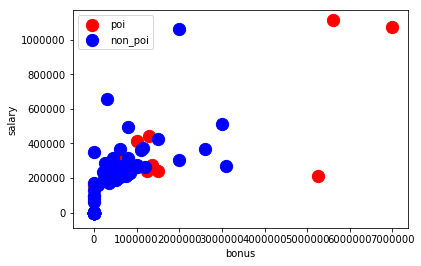

In [13]:
# View top 2 visually:
poi_scatter(labels_train, features_train, x=rank[0], y=rank[1], \
           x_label=features_list[1:][rank[0]], y_label=features_list[1:][rank[1]])

In [14]:
trans_features_train = selector.transform(features_train)
trans_features_test = selector.transform(features_test)
clf.fit(trans_features_train, labels_train)
pred = clf.predict(trans_features_test)
clf_test(labels_test, pred)

Accuracy:  0.840909090909
Recall:  0.4
Precision:  0.333333333333


In [15]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

#dump_classifier_and_data(clf, my_dataset, features_list)